# MPC（モデル予測制御）をMMG4に適用する

# MMG4モデルの関数

In [246]:
def X_H(u,v,r,φ):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    return 0.5*ρ*L_pp*d*U**2*X_H_dash(v,r_dash,φ)

def Y_H(u,v,r,φ):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    return 0.5*ρ*L_pp*d*U**2*Y_H_dash(v,r_dash,φ)

def N_H(u,v,r,φ):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    return 0.5*ρ*L_pp*d*U**2*N_H_dash(v,r_dash,φ)

def K_H(u,v,r,φ):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    return -0.5*ρ*L_pp*d*U**2*K_H_dash(v,r_dash,φ)


In [247]:


def X_H_dash(v_dash,r_dash,φ):
    return X_0_dash * (1 + c_x0 * (-φ)) + X_rφ_dash * r_dash * φ + X_vv_dash * (1 + c_xββ * (-φ)) * (v_dash**2) + (X_vr_dash - m_y_dash) * v_dash * r_dash + X_rr_dash * (1 + c_xrr * (-φ)) * (r_dash**2) + X_vvvv_dash * (v_dash**4)


def Y_H_dash(v_dash,r_dash,φ):
    return Y_φ_dash * φ + Y_v_dash * (1 + c_yβ * (-φ)) * v_dash + (Y_r_dash - m_x_dash) * (1 + c_yr * (-φ)) * r_dash + Y_vvφ_dash * (v_dash**2) * φ + Y_vrφ_dash * v_dash * r_dash * φ + Y_rrφ_dash * (r_dash**2) * φ + Y_vvv_dash * (v_dash**3) + Y_vvr_dash * (v_dash**2) * r_dash + Y_vrr_dash * v_dash * (r_dash**2) + Y_rrr_dash * (r_dash**3)

def N_H_dash(v_dash,r_dash,φ):
    return N_φ_dash * φ + N_v_dash * (1 + c_nβ * (-φ)) * v_dash + N_r_dash * (1 + c_nr * (-φ)) * r_dash + N_vvφ_dash * (v_dash**2) * φ + N_vrφ_dash * v_dash * r_dash * φ + N_rrφ_dash * (r_dash**2) * φ + N_vvv_dash * (v_dash**3) + N_vvr_dash * (v_dash**2) * r_dash + N_vrr_dash * v_dash * (r_dash**2) + N_rrr_dash * (r_dash**3)

def K_H_dash(v_dash,r_dash,φ):
    return K_φ_dash * φ + K_v_dash * v_dash + K_r_dash * r_dash + K_vvφ_dash * (v_dash**2) * φ + K_vrφ_dash * v_dash * r_dash * φ + K_rrφ_dash * (r_dash**2) * φ + K_vvv_dash * (v_dash**3) + K_vvr_dash * (v_dash**2) * r_dash + K_vrr_dash * v_dash * (r_dash**2) + K_rrr_dash * (r_dash**3) + K_vvr_dash * (v_dash**2) * r_dash + K_vrr_dash * v_dash * (r_dash**2) + K_rrr_dash * (r_dash**3)


In [248]:
def X_R(u,v,δ,n_p,φ):
    return -(1-t_P)*F_N(u,v,δ,n_p)*np.sin(δ)*np.cos(φ)

def Y_R(u,v,δ,n_p,φ):
    return -(1+a_H)*F_N(u,v,δ,n_p)*np.cos(δ)*np.cos(φ)

def N_R(u,v,δ,n_p,φ):
    return -(x_R+a_H*x_H)*F_N(u,v,δ,n_p)*np.cos(δ)*np.cos(φ)

def K_T(u,n_p):
    return k_0+k_1*J(u,n_p)+k_2*J(u,n_p)**2

def J(u,n_p):
    return u*(1-w_P0)/(n_p*D_p)

def T_P(u,n_p):
    return K_T(u,n_p)*ρ*n_p**2*D_p**4

def F_N(u,v,δ,n_p):
    u_p=(1-w_P0)*u
    u_inf=u_p*np.sqrt(1+(8*K_T(u,n_p))/(np.pi*J(u,n_p)**2))
    k_x=κ*ϵ
    delta_u=u_inf-u_p
    u_RP=u_p+k_x*delta_u
    u_R=np.sqrt(η*u_RP**2+(1-η)*u_p**2)
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/U)
    r_dash=r*L_pp/U
    v_R=U*γ_R_plus*(β-l_r_dash*r_dash)
    α_R=δ-np.arctan(v_R/u_R)
    return 0.5*ρ*A_R*u_R**2*f_α*np.sin(α_R)

def X_P(u,n_p):
    return (1-t_R)*ρ*K_T(u,n_p)*n_p**2*D_p**4


In [249]:
import numpy as np
import do_mpc
from casadi import *

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

モデルの種類の決定

In [250]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

# 変数の設定
入出力の変数設定
- 状態量 : var_type='_x'
- 操作量 : var_type='_u'  
$ δ $ : 舵角  
$ n_p $ : プロペラ回転数  
$ u $ : 船首方向の船速  
$ v $ : 横方向の船速  
$ r $ : 旋回角速度  
$ x, y $ : 船の座標  
$ ψ $ : 船首角(船首とx軸正の向きの角度)  

In [251]:
δ = model.set_variable(var_type='_u', var_name='δ', shape=(1,1)) #舵角
n_p=model.set_variable(var_type='_u',var_name='n_p',shape=(1,1)) #プロペラ回転数

u = model.set_variable(var_type='_x', var_name='u', shape=(1,1)) #前後方向速度
v = model.set_variable(var_type='_x', var_name='v', shape=(1,1)) #横方向速度
r = model.set_variable(var_type='_x', var_name='r', shape=(1,1)) #回頭角速度
x = model.set_variable(var_type='_x', var_name='x', shape=(1,1)) #船のx座標
y = model.set_variable(var_type='_x', var_name='y', shape=(1,1)) #船のy座標
ψ = model.set_variable(var_type='_x', var_name='ψ', shape=(1,1)) #船首角(x軸正の方向となす角)
φ = model.set_variable(var_type='_x', var_name='φ', shape=(1,1)) #横傾斜角
d_φ=model.set_variable(var_type='_x',var_name='d_φ',shape=(1,1)) #横傾斜角の微分

##### パラメータの設定
時間によって変化しないパラメータを設定する

In [252]:
ρ = 1025.0  # 海水密度

# KCS Container Ship
L_pp = 2.1905  # 船長Lpp[m]
B = 0.3067  # 船幅[m]
d = 0.1029  # 喫水[m]
nabla = 0.0449  # 排水量[m^3]　
x_G = -0.03242  # 重心位置[m] 
# C_b = 0.810  # 方形係数[-]
D_p = 0.0756  # プロペラ直径[m]
H_R = 0.0954  # 舵高さ[m]　
A_R = 0.0042076  # 舵断面積[m^2]

t_P = 0.178  # 推力減少率
w_P0 = 0.353  # 有効伴流率
m_x_dash = 0.0060  # 付加質量x(無次元)　
m_y_dash = 0.1521  # 付加質量y(無次元)　
# J_z_dash = 0.011  # 付加質量Izz(無次元)　まだ
J_z_dash = 0.005  # 付加質量Izz(無次元)　まだ
t_R = 0.441  # 操縦抵抗減少率
x_R_dash = -0.500  # 舵の相対位置
a_H = 0.232  # 舵力増加係数
x_H_dash = -0.711  # 舵力増分作用位置
γ_R_minus = 0.412  # 整流係数　まだ　
γ_R_plus = 0.412  # 整流係数　まだ
l_r_dash = -0.774  # 船長に対する舵位置
x_P_dash = -0.480  # 船長に対するプロペラ位置　まだ 多分これでok
ϵ = 0.900  # プロペラ・舵位置伴流係数比
κ = 0.713  # 修正係数
f_α = 3.0081  # 直圧力勾配係数　教科書p24

# 追加
z_G = 0.01 #船体上下重心位置
a = 0.1 #横揺れ減衰曲線の線形係数
GM = 0.6
# C_44 = 9.81 * m * GM #復原力係数 OK(7/19)
# I_xx = 0.270568
# J_xx = 0.004666
# B_44 = (2 * a) / np.pi * np.sqrt(C_44 * (I_xx + J_xx)) #横揺れ減衰係数

C_44=9.81 * ρ * nabla * GM
I_xx=ρ * nabla * ((0.25 * B) ** 2)
J_xx=(0.5 * ρ * (B ** 4) * d) * 0.01
B_44=(2 * a) / np.pi * np.sqrt((9.81 * ρ * nabla * GM) * ((ρ * nabla * ((0.25 * B) ** 2)) + J_xx))
m=ρ * nabla  # 質量(無次元化)[kg]
I_zG=ρ * nabla * ((0.25 * L_pp) ** 2)  # 慣性モーメント[-]
η=D_p / H_R # プロペラ直径に対する舵高さ(Dp/H)
m_x=(0.5 * ρ * (L_pp ** 2) * d) * m_x_dash  # 付加質量x(無次元)
m_y=(0.5 * ρ * (L_pp ** 2) * d) * m_y_dash  # 付加質量y(無次元)
J_z=(0.5 * ρ * (L_pp ** 4) * d) * J_z_dash  # 付加質量Izz(無次元)
x_H=x_H_dash * L_pp  # 舵力増分作用位置
x_R=x_R_dash * L_pp  # 舵の相対位置


z_R = 0.08 #舵の幾何学的図心 OK (7/19)
z_H = 0.05145 #喫水中央 OK (7/19)
c_x0 = -0.12
# x
c_xββ = 2.31               
c_xrr = 3.50
# y
c_yβ = 0.05 
c_yr = -1.20
c_nβ = 0.21
c_nr = -0.32

k_0 = 0.50278
k_1 = -0.29546
k_2 = -0.18095
R_0_dash = 0.0183
X_0_dash = -0.0183
X_rφ_dash = 0.0258
X_vv_dash = -0.0603
X_vr_dash = -(-0.1218 + m_y_dash)
X_rr_dash = -0.0162
X_vvvv_dash = -0.0760
Y_φ_dash = -0.0052
Y_v_dash = -0.2162
Y_r_dash = 0.0245 + m_x_dash
Y_vvφ_dash = 0.3352
Y_vrφ_dash = -0.3123
Y_rrφ_dash = -0.0642
Y_vvv_dash = -1.7028
Y_vvr_dash = -0.5658
Y_vrr_dash = -0.8564
Y_rrr_dash = -0.0105
N_φ_dash = -0.0063
N_v_dash = -0.1172
N_r_dash = -0.0443
N_vvφ_dash = -0.2532
N_vrφ_dash = -0.1152
N_rrφ_dash = -0.0120
N_vvv_dash = -0.1710
N_vvr_dash = -0.5602
N_vrr_dash = -0.0200
N_rrr_dash = -0.0369
K_φ_dash = -0.0299
K_v_dash = 0.1367
K_r_dash = 0.0085
K_vvφ_dash = 0.2819
K_vrφ_dash = -0.2997
K_rrφ_dash = -0.0487
K_vvv_dash = 1.4352
K_vvr_dash = 1.1636
K_vrr_dash = 0.4233
K_rrr_dash = 0.0363

### 微分方程式の設定

$
\displaystyle
\dot{u}=\frac{X_H+X_R+X_P+(m+m_y)vr}{m+m_x}  \\
\displaystyle
\dot{v}=\frac{Y_H+Y_R-(m+m_x)ur}{m+m_y}  \\
\displaystyle
\dot{r}=\frac{N_H+N_R-x_G(Y_H+Y_R)}{I_Z+J_Z}  \\
\displaystyle
\dot{x}=u\cos{\psi}-v\sin{\psi}  \\
\displaystyle
\dot{y}=u\sin{\psi}+v\cos{\psi}  \\
\displaystyle
\dot{\psi}=r  \\
\displaystyle
(I_x+J_x)\ddot{\phi}-(z_H-z_G)(m_y\dot{v}+m_xur)=K_H+z_GY_H-B_{44}\dot{\phi}-C_{44}\phi-(z_R-z_G)Y_R  \\
$

In [253]:
rad = np.pi / 180 #rad変換

In [254]:
model.set_rhs('u', (X_H(u,v,r,φ)+X_R(u,v,δ,n_p,φ)+X_P(u,n_p)+(m+m_y)*v*r)/(m+m_x))
model.set_rhs('v', (Y_H(u,v,r,φ)+Y_R(u,v,δ,n_p,φ))/(m+m_y))
model.set_rhs('r', (N_H(u,v,r,φ)+N_R(u,v,δ,n_p,φ)-x_G*(Y_H(u,v,r,φ)+Y_R(u,v,δ,n_p,φ)))/(I_zG+J_z))
model.set_rhs('x', u * np.cos(ψ) - v * np.sin(ψ))
model.set_rhs('y', u * np.sin(ψ) + v * np.cos(ψ))
model.set_rhs('ψ', r)

model.set_rhs('φ', d_φ)
d_φ_next = -(K_H(u,v,r,φ)+z_G*Y_H(u,v,r,φ)-B_44*d_φ*rad-C_44*φ*rad-(z_R-z_G)*Y_R(u,v,δ,n_p,φ)+(z_H-z_G)*(m_y*((Y_H(u,v,r,φ)+Y_R(u,v,δ,n_p,φ))/(m+m_y))+m_x*u*r))/((I_xx+J_xx)*rad)
model.set_rhs('d_φ', d_φ_next)

In [255]:
# d_φ_next = (K_H(u,v,r,φ)+z_G*Y_H(u,v,r,φ)-B_44*d_φ-C_44*φ-(z_R-z_G)*Y_R(u,v,δ,n_p,φ)+(z_H-z_G)*(m_y*((Y_H(u,v,r,φ)+Y_R(u,v,δ,n_p,φ))/(m+m_y))+m_x*u*r0))/(I_xx+J_xx)
# model.set_rhs('d_φ', d_φ_next)

In [256]:
model.setup()

## MPCコントローラの形成

In [257]:
mpc = do_mpc.controller.MPC(model)

n_horizon = 30
t_step = 1.0
n_robust = 1 # default to 0
store_full_solution = True

setup_mpc = {
    'n_horizon': n_horizon,
    't_step': t_step,
    'n_robust': n_robust,
    'store_full_solution': store_full_solution,
}
mpc.set_param(**setup_mpc)

### 評価関数の設定

$
C=\sum_{k=0}^{n-1}(\underbrace{l\left(x_{k}, u_{k}, z_{k}, p\right)}_{\text {lagrange term }}+\underbrace{\Delta u_{k}^{T} R \Delta u_{k}}_{\text {r-term }})+\underbrace{m\left(x_{n}\right)}_{\text {meyer term }}
$

今回は、目標軌道を追従するような目的関数を設定する

時刻kごとに目標座標$x_k^{ref},y_k^{ref}$を変化させることで軌道追従ができる 

$lagrange term=\sum_{k=0}^{n-1}((x_k-x_k^{ref})^2+(y_k-y_k^{ref})^2)$  
$r-term=\Delta u_k^TR\Delta u_k$  
$meyer=(x_n-x_n^{ref})^2+(y_n-y_n^{ref})^2$

In [258]:
target_r=0.05
lterm=(r-target_r)**2
mterm=lterm
mpc.set_objective(mterm=mterm,lterm=lterm)

$\Delta u_k^TR\Delta u_k$の設定

In [259]:
mpc.set_rterm(δ = 1e-3)

### 変数の制約

In [260]:
mpc.bounds['lower','_u', 'δ'] = - 45 * np.pi / 180
mpc.bounds['upper','_u', 'δ'] = 45 * np.pi / 180
mpc.bounds['lower','_x','u']=0.0
mpc.bounds['upper','_x','u']=15.0
mpc.bounds['lower','_x','v']=-5.0
mpc.bounds['upper','_x','v']=5.0
mpc.bounds['lower','_u','n_p']=0.0
mpc.bounds['upper','_u','n_p']=20.0
mpc.bounds['lower','_x','φ']=-0.5
mpc.bounds['upper','_x','φ']=0.5

In [261]:
mpc.setup()

## シミュレータの設定

In [262]:
simulator = do_mpc.simulator.Simulator(model)

In [263]:
simulator.set_param(t_step = 1)

In [264]:
simulator.setup()

## コントロールループの設定

### 初期値の設定

状態量の初期値を設定する.  
最初に設定した状態量の変数すべてに初期値を設定する必要がある  
その初期値をsimulatorとmpcの両方に設定する

In [265]:
x0 = np.array([3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).reshape(-1,1)
simulator.x0 = x0
mpc.x0 = x0
mpc.set_initial_guess()

In [266]:
mpc.x0.keys()

['u', 'v', 'r', 'x', 'y', 'ψ', 'φ', 'd_φ']

### グラフの設定

In [267]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [268]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(4, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [269]:
%%capture
for g in [sim_graphics, mpc_graphics]:
#     g.add_line(var_type='_x', var_name='x', axis=ax[0])
    g.add_line(var_type='_x', var_name='y', axis=ax[0])
    g.add_line(var_type='_x', var_name='ψ', axis=ax[1])
    g.add_line(var_type='_u', var_name='δ', axis=ax[2])
    g.add_line(var_type='_x', var_name='φ', axis=ax[3])
    
ax[0].set_ylabel('[m]')
ax[1].set_ylabel('azimuth [rad]')
ax[2].set_ylabel('delta [rad]')
ax[3].set_ylabel('φ [rad]')
ax[3].set_xlabel('time [s]')

### MPCの最適化を実施

In [270]:
u0 = mpc.make_step(x0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4148
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1410

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Total number of variables............................:     1052
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      408
                     variables with only upper bounds:        0
Total number of equality constraints.................:      968
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective  

CasADi - 2023-10-11 12:57:05 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 24 (row 8, col 32).") [.../casadi/core/oracle_function.cpp:326]


In [271]:
u0 = mpc.make_step(x0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4148
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1410

Total number of variables............................:     1052
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      408
                     variables with only upper bounds:        0
Total number of equality constraints.................:      968
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5001694e-03 1.08e-01 7.35e-06  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

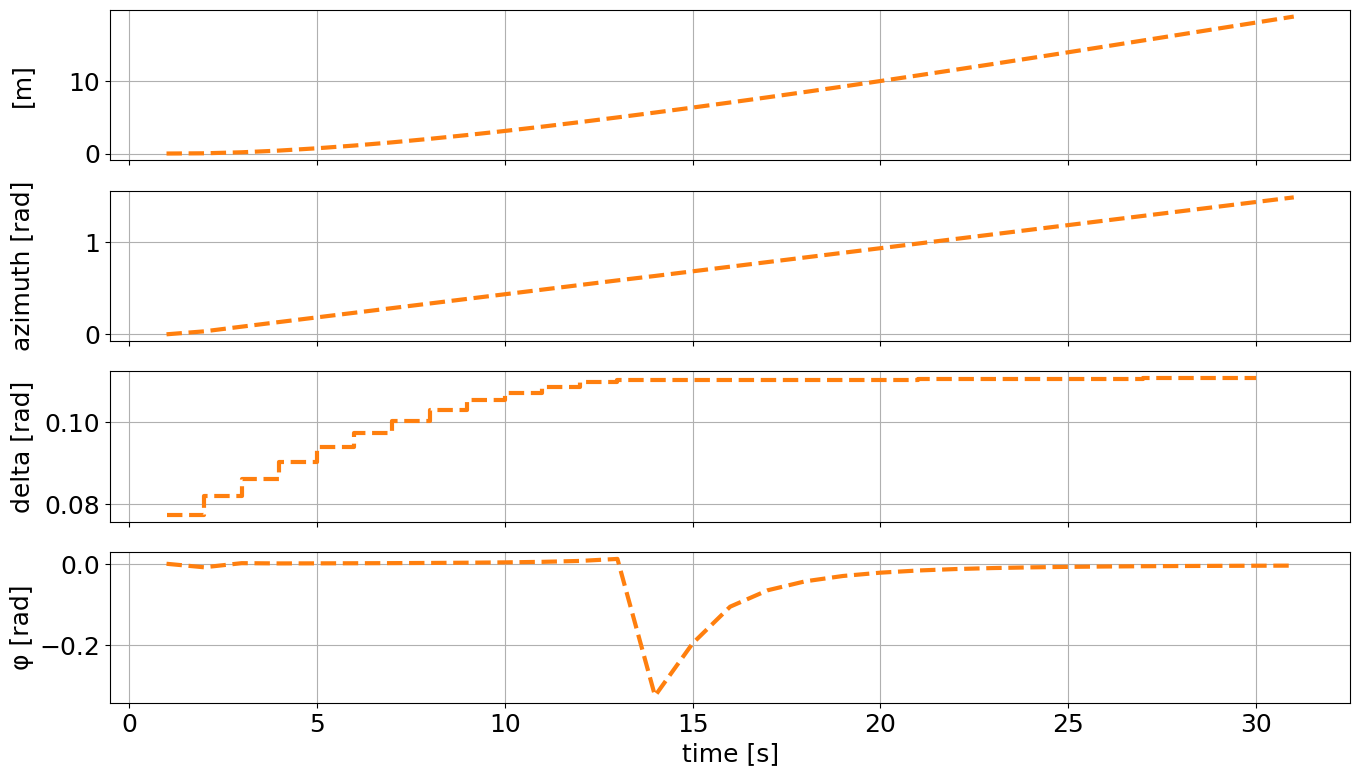

In [272]:
sim_graphics.clear()
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig

In [273]:
# simulator.reset_history()
# simulator.x0 = x0
# mpc.reset_history()

In [274]:
%%capture
for i in range(n_horizon):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

RuntimeError: Error in Function::call for 'simulator' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'simulator' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

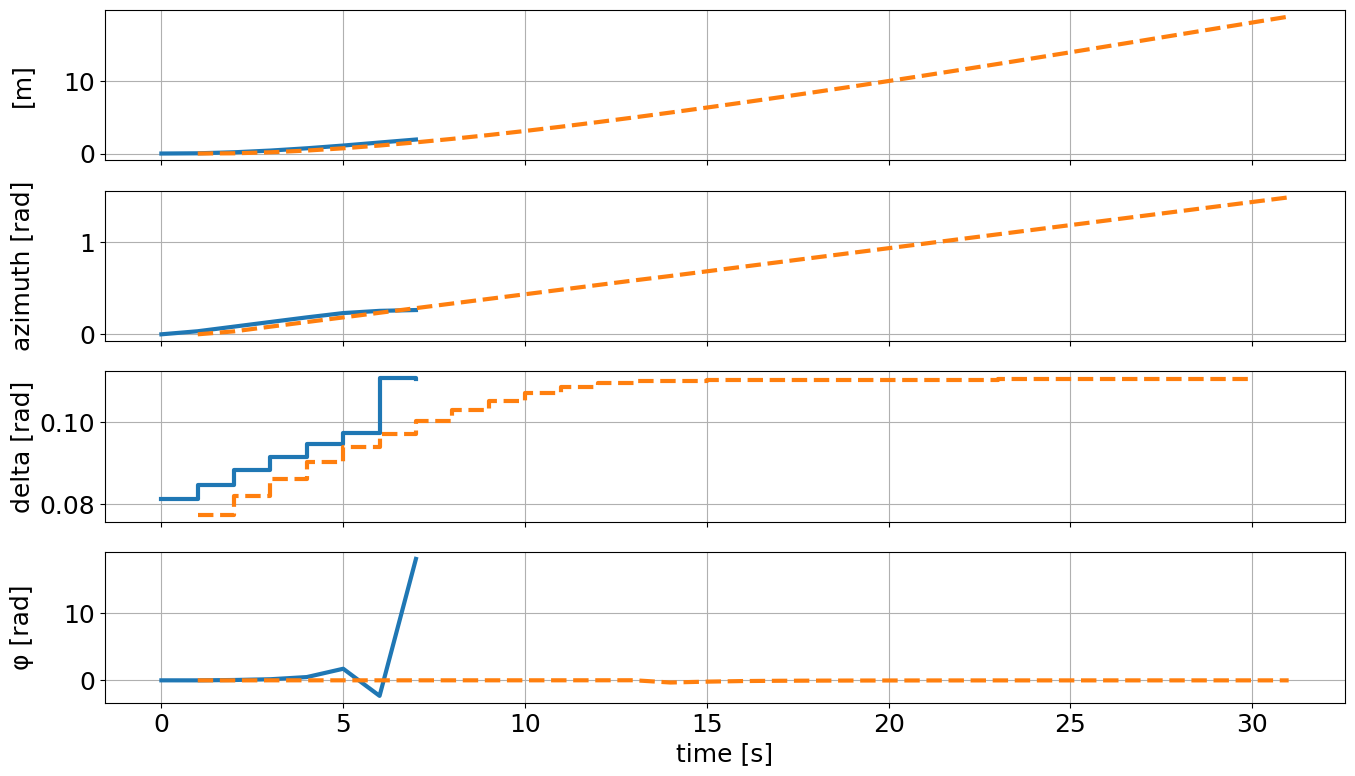

In [275]:
sim_graphics.clear()
mpc_graphics.clear()
# Plot predictions from t=0
# mpc_graphics.plot_predictions(t_ind=0)
# Plot results until current time
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig